## Yu Pekkarnuz Mitochondrial Mass Spectrometry Data Analysis

#### Thomas Whisenant, CCBB, UCSD (twhisenant@ucsd.edu)




<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Input Parameters](#param)
3. [Environment Set-Up](#environ)
4. [Data Loading and Pre-Processing](#load)
5. [Import Perseus Processed Data](#import)
6. [Testing for Differential Binding](#diffbind)
7. [Overlap Analysis](#overlap)
8. [Enrichment Analysis](#enrich)
9. [Generate Plots for Figures](#GenerateFigPlots)
10. [References](#ref)
11. [Appendix: R Session Info](#app)


### Background
<a id='background'></a>
The data includes 6 proteomic data points from two different treatments of isolated mitochondria. The proteins extracted from the mitochondria have been enriched for O-GlcNac conjugated proteins. The two treatments are +/- TMG. 

Samples were processed and analyzed by the UCSD Mass Spectrometry Core Facility. Quantitative peptide analysis was performed using PEAKS Studio 8.5. The manual can be found here: https://www.bioinfor.com/wp-content/uploads/2017/08/PEAKS_Studio_85_Manual.pdf

[Table of Contents](#toc)



### Input Parameters
<a id='param'></a>
Data Provided:

For each set of 3 replicates per sample group (matched):

* 3 individual folders with label free quantification results for pairs of samples (+/- TMG) from each mass spectrometry run.

* In each quantification folder, there are two relevant files:
    1. protein-peptides.csv - list of peptides for each sample 
    2. proteins.csv - list of proteins and their quantifications for each samples
    3. peptides.html - list/images of peptides for each sample 
    4. proteins.html - list/images of proteins and their quantifications for each samples


[Table of Contents](#toc)

In [1]:
All_meta <- data.frame(SampleName=c("P1_A", "P1_B", "P2_A", "P2_B", "P3_A", "P3_B"),
                       MassSpecName=c("SampleA", "SampleB", "SampleA", "SampleB", "Gul_A_HCD", "Gul_B_HCD"),
                       RunDate=c("20180531", "20180531", "20180710", "20180710", "20180816", "20180816"),
                       Treatment=c("plusTMG", "minusTMG","plusTMG", "minusTMG","plusTMG", "minusTMG"))
All_meta

SampleName,MassSpecName,RunDate,Treatment
<chr>,<chr>,<chr>,<chr>
P1_A,SampleA,20180531,plusTMG
P1_B,SampleB,20180531,minusTMG
P2_A,SampleA,20180710,plusTMG
P2_B,SampleB,20180710,minusTMG
P3_A,Gul_A_HCD,20180816,plusTMG
P3_B,Gul_B_HCD,20180816,minusTMG


###  Environment Setup
<a id='environ'></a>

[Table of Contents](#toc)

In [4]:
# This line prevents SVG output, which interacts badly with export to HTML
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

In [10]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("edgeR")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.8 (BiocManager 1.30.18), R 3.5.1 (2018-07-02)

Installing package(s) 'edgeR'

Warning message:
“dependency ‘locfit’ is not available”
Warning message in install.packages(...):
“installation of package ‘edgeR’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'backports', 'bibtex', 'bit', 'bit64', 'bitops', 'blob', 'broom',
  'car', 'carData', 'caret', 'class', 'cli', 'clipr', 'cluster', 'codetools',
  'colorspace', 'config', 'corpcor', 'crayon', 'curl', 'data.table', 'DBI',
  'dendextend', 'Deriv', 'digest', 'doParallel', 'doSNOW', 'dplyr', 'e1071',
  'ellipsis', 'evaluate', 'exactRankTests', 'fansi', 'farver', 'forcats',
  'foreach', 'gbm', 'gdata', 'generics', 'ggplot2', 'ggpubr', 'ggrepel',
  'ggsignif', 'globals', 'glue', 'gower

In [2]:
#source("https://bioconductor.org/biocLite.R")
#biocLite("org.Hs.eg.db")
library(org.Rn.eg.db)
library(limma)
library(stringr) 
library(ggplot2)
library(gplots)
library(ggpubr)
library(plyr)
library(dplyr)
library(RColorBrewer)
library(org.Hs.eg.db)
library(reshape2)
library(ggrepel)
library(gprofiler2)
#library(Glimma)
library(IRdisplay)
EG2SYM <- toTable(org.Rn.egSYMBOL)
EG2AltSYM <- toTable(org.Rn.egALIAS2EG)



Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: IRanges

Loading required package: S4Vectors


Atta

In [3]:
runLimma <- function(dat, met=meta, norm=FALSE, filt=TRUE) {
    des <- model.matrix(~0 + met$Treatment + met$Group)
    colnames(des) <- gsub("^met\\$", "", colnames(des))
    rownames(des) <- as.character(met$Sample)
    cm <- makeContrasts(TreatmentB - TreatmentA, levels=des)
    vfit <- lmFit(dat, des)
    vfit <- contrasts.fit(vfit, contrasts=cm)
    efit <- eBayes(vfit)
    topTab <- topTable(efit, n=Inf, coef=1,  sort.by="p")
    topTab <- topTab[!is.na(topTab$logFC),]
    dt <- decideTests(efit,p.value = 0.1)
    dt[is.na(dt[,1]),1] <- 0
    list(topTab, dt, efit)
}

In [4]:
runGProfiler2onGL = function(gl, bkgd, name, species, outputDir, maxAdjPVal=0.05){
    tryCatch({
        top <- gl[!is.na(gl)]
        top <- top[!duplicated(top)]
        ALL_genes <- bkgd$SYMBOL
        ALL_genes <- bkgd[!is.na(bkgd)]
                
        gostres <- gost(query = top, 
                        organism = species, 
                        ordered_query = FALSE, 
                        multi_query = FALSE, 
                        significant = TRUE, 
                        exclude_iea = FALSE,
                        measure_underrepresentation = FALSE, 
                        evcodes = TRUE,
                        user_threshold = maxAdjPVal, 
                        correction_method = "fdr",
                        domain_scope = "custom_annotated", 
                        custom_bg = ALL_genes, 
                        numeric_ns = "", 
                        sources = NULL, 
                        as_short_link = FALSE)
        
        gpro_res <- gostres$result[,c("p_value", "term_size", "query_size", "intersection_size", "precision","recall", "term_id", "source", "term_name", "intersection")]
        write.csv(gpro_res, sprintf('%s/%s_GProfiler_ORA_strict_%s.csv', outputDir, gRunName, name), row.names = FALSE)
        
        p <- gostplot(gostres, capped = FALSE, interactive = FALSE)
        pp <- publish_gostplot(p, highlight_terms = gostres$result[c(1:5),], width = NA, height = NA, 
                               filename = sprintf("%s/%s_GProfiler_plot_ORA_strict_%s.pdf", outputDir, gRunName, name))
        gostres_link <- gost(query = top, 
                             organism = species, 
                             ordered_query = FALSE, 
                             multi_query = FALSE, 
                             significant = TRUE, 
                             exclude_iea = FALSE, 
                             measure_underrepresentation = FALSE, 
                             evcodes = TRUE, 
                             user_threshold = 0.05, 
                             correction_method = "fdr", 
                             domain_scope = "custom_annotated", 
                             custom_bg = ALL_genes, 
                             numeric_ns = "", 
                             sources = NULL, 
                            as_short_link = TRUE)
        link_df <- data.frame("Contrast" = name, "GProfiler_interactive_link" = gostres_link)
        write.csv(link_df, sprintf("%s/%s_Gprofiler_interactive_linkdf_%s.csv", outputDir, gRunName, name), row.names = FALSE)
    }, error=function(e){print(paste0("runGProfiler2 failed for maxAdjPval <", maxAdjPVal, " with message:", e))})
}


### Data Loading and Pre-Processing
<a id='load'></a>


1. The original unprocessed protein level data file (proteins.csv) includes protein identifiers and two sets of quantification values that are the same for each sample. The LFQ quantification of the samples will be used as recommended by the creators of the software used to generate the data file (1).
2. All the irrelevant proteins have been previously removed including: a. proteins hits from a "Reverse" database which can be removed by the regular expression "^REV". b. proteins identified as contaminants which can be removed by the regular expression "^CON" c. proteins flagged as "Only identified by site" which can be removed by filtering "+" values rows
3. Each quantification dataset and set of threshold parameters will be analyzed prior to determining the best input for differential analysis

We will start with the following guidelines for the analysis:
1. The pipeline used to identify proteins found in 1 or both groups and subsequent visualizations:
    A. Import quantification data for each individual group
    B. log2 Transformation of the raw quantified values (+ 1.1 pseduosignal to avoid NA values)
2. The pipeline used to generate the input for differential analysis incorporated the following steps:
    A. Import quantification data for combined groups
    B. log2 Transformation of the raw quantified values 
    C. Removal of proteins with limited detection
    
        1. Removal of proteins not identified in 50% or more of the samples in 1 or both groups 
        2. Removal of proteins not identified in 100% of samples
    
    D. Width Adjustment based normalization using the Perseus software 
    E. Imputation from a normal distribution for missing data points.

[Table of Contents](#toc)

In [5]:
proj1 <- read.csv(file="./Data/proteins_Round1.csv", header=TRUE)
proj2 <- read.csv(file="./Data/proteins_Round2.csv", header=TRUE)
proj3 <- read.csv(file="./Data/proteins_Round3.csv", header=TRUE)
proj3 <- proj3[proj3$Significance > 0,]

Quantification values are properly treated as intensities and intensities are usually log2-transformed in order to generate approximately normal distributions for statistical analysis. However, log2 is -infinity for zero, so it is necessary to add a small pseudosignal to all values so that none are zero. To determine what an appropriately small value is, examine the minimum non-zero value in all samples:

A pseudosignal of 1.1 will therefore be miniscule even compared to the smallest non-zero signal, so 1.1 is added to all values. Then the values are log transformed:

In [6]:
proj1_log <- apply(proj1[,9:10], 2, function(x) as.numeric(gsub("-", "0", as.character(x))) + 1.1)
proj1_log <- round(apply(proj1_log, 2, function(x) log2(x)), 1) 
rownames(proj1_log) <- gsub("_RAT$", "", unlist(lapply(strsplit(as.character(proj1$Accession), "\\|"), function(x) x[[2]])))

proj2_log <-  apply(proj2[,9:10], 2, function(x) as.numeric(gsub("-", "0", as.character(x))) + 1.1)
proj2_log <- round(apply(proj2_log, 2, function(x) log2(x)), 1) 
rownames(proj2_log) <- gsub("_RAT$", "", unlist(lapply(strsplit(as.character(proj2$Accession), "\\|"), function(x) x[[2]])))

proj3_log <-  apply(proj3[,9:10], 2, function(x) as.numeric(gsub("-", "0", as.character(x))) + 1.1)
proj3_log <- round(apply(proj3_log, 2, function(x) log2(x)), 1) 
rownames(proj3_log) <- gsub("_RAT$", "", unlist(lapply(strsplit(as.character(proj3$Accession), "\\|"), function(x) x[[2]])))


In [7]:
proj1_filt <- subset(proj1, Sample.1.Area != 0 | Sample.2.Area != 0)
proj2_filt <- subset(proj2, Sample.1.Area != 0 | Sample.2.Area != 0)
proj3_filt <- subset(proj3, Sample.2.Area != 0 | Sample.4.Area != 0)
proj1_filtB <- proj1[proj1$X.Peptides > 1,]
proj2_filtB <- proj2[proj2$X.Peptides > 1,]
proj3_filtB <- proj3[proj3$X.Peptides > 1,]

In [8]:
merged_proj_venninp <- as.data.frame(matrix(0, nrow=length(unique(c(as.character(proj1$Accession),
                                                                   as.character(proj2$Accession),
                                                                   as.character(proj3$Accession)))), ncol=3))
merged_proj_raw <- merged_proj_raw_log<- as.data.frame(matrix(0, nrow=length(unique(c(as.character(proj1$Accession),
                                                                as.character(proj2$Accession),
                                                                as.character(proj3$Accession)))), ncol=6))
merged_proj_pep <- as.data.frame(matrix(0, nrow=length(unique(c(as.character(proj1$Accession),
                                                                as.character(proj2$Accession),
                                                                as.character(proj3$Accession)))), ncol=3))
rownames(merged_proj_pep) <- rownames(merged_proj_raw) <- rownames(merged_proj_venninp) <- 
rownames(merged_proj_raw_log) <- unique(c(as.character(proj1$Accession),as.character(proj2$Accession),
                                            as.character(proj3$Accession)))
colnames(merged_proj_pep) <- colnames(merged_proj_venninp) <- c("Project1", "Project2", "Project3")
colnames(merged_proj_raw) <- colnames(merged_proj_raw_log) <- c("P1_A", "P1_B", "P2_A", "P2_B", "P3_A", "P3_B")

merged_proj_pep[which(rownames(merged_proj_pep) %in% as.character(proj1$Accession)), 1] <-  proj1$X.Peptides[match(rownames(merged_proj_pep)[which(rownames(merged_proj_pep) %in% 
                                                                                            as.character(proj1$Accession))], as.character(proj1$Accession))]
merged_proj_pep[which(rownames(merged_proj_pep) %in% as.character(proj2$Accession)), 2] <-  proj2$X.Peptides[match(rownames(merged_proj_pep)[which(rownames(merged_proj_pep) %in% 
                                                                                            as.character(proj2$Accession))], as.character(proj2$Accession))]
merged_proj_pep[which(rownames(merged_proj_pep) %in% as.character(proj3$Accession)), 3] <-  proj3$X.Peptides[match(rownames(merged_proj_pep)[which(rownames(merged_proj_pep) %in% 
                                                                                            as.character(proj3$Accession))], as.character(proj3$Accession))]

merged_proj_venninp[which(rownames(merged_proj_venninp) %in% as.character(proj1$Accession)), 1] <-  1
merged_proj_venninp[which(rownames(merged_proj_venninp) %in% as.character(proj2$Accession)), 2] <-  1
merged_proj_venninp[which(rownames(merged_proj_venninp) %in% as.character(proj3$Accession)), 3] <-  1

merged_proj_raw[which(rownames(merged_proj_raw) %in% as.character(proj1$Accession)), 1] <-  proj1$Sample.1.Area[match(rownames(merged_proj_raw)[which(rownames(merged_proj_raw) %in% 
                                                                                            as.character(proj1$Accession))], as.character(proj1$Accession))]
merged_proj_raw[which(rownames(merged_proj_raw) %in% as.character(proj1$Accession)), 2] <-  proj1$Sample.2.Area[match(rownames(merged_proj_raw)[which(rownames(merged_proj_raw) %in% 
                                                                                            as.character(proj1$Accession))], as.character(proj1$Accession))]
merged_proj_raw[which(rownames(merged_proj_raw) %in% as.character(proj2$Accession)), 3] <-  proj2$Sample.1.Area[match(rownames(merged_proj_raw)[which(rownames(merged_proj_raw) %in%
                                                                                            as.character(proj2$Accession))], as.character(proj2$Accession))]
merged_proj_raw[which(rownames(merged_proj_raw) %in% as.character(proj2$Accession)), 4] <-  proj2$Sample.2.Area[match(rownames(merged_proj_raw)[which(rownames(merged_proj_raw) %in% 
                                                                                            as.character(proj2$Accession))], as.character(proj2$Accession))]
merged_proj_raw[which(rownames(merged_proj_raw) %in% as.character(proj3$Accession)), 5] <-  proj3$Sample.2.Area[match(rownames(merged_proj_raw)[which(rownames(merged_proj_raw) %in% 
                                                                                            as.character(proj3$Accession))], as.character(proj3$Accession))]
merged_proj_raw[which(rownames(merged_proj_raw) %in% as.character(proj3$Accession)), 6] <-  proj3$Sample.4.Area[match(rownames(merged_proj_raw)[which(rownames(merged_proj_raw) %in% 
                                                                                            as.character(proj3$Accession))], as.character(proj3$Accession))]
merged_proj_raw_log[which(rownames(merged_proj_raw_log) %in% as.character(proj1$Accession)), 1] <-  proj1_log[match(rownames(merged_proj_raw_log)[which(rownames(merged_proj_raw_log) %in% 
                                                                                                                      as.character(proj1$Accession))], as.character(proj1$Accession)), 1]
merged_proj_raw_log[which(rownames(merged_proj_raw_log) %in% as.character(proj1$Accession)), 2] <-  proj1_log[match(rownames(merged_proj_raw_log)[which(rownames(merged_proj_raw_log) %in% 
                                                                                                                      as.character(proj1$Accession))], as.character(proj1$Accession)), 2]
merged_proj_raw_log[which(rownames(merged_proj_raw_log) %in% as.character(proj2$Accession)), 3] <-  proj2_log[match(rownames(merged_proj_raw_log)[which(rownames(merged_proj_raw_log) %in%
                                                                                                                      as.character(proj2$Accession))], as.character(proj2$Accession)), 1]
merged_proj_raw_log[which(rownames(merged_proj_raw_log) %in% as.character(proj2$Accession)), 4] <-  proj2_log[match(rownames(merged_proj_raw_log)[which(rownames(merged_proj_raw_log) %in% 
                                                                                                                      as.character(proj2$Accession))], as.character(proj2$Accession)), 2]
merged_proj_raw_log[which(rownames(merged_proj_raw_log) %in% as.character(proj3$Accession)), 5] <-  proj3_log[match(rownames(merged_proj_raw_log)[which(rownames(merged_proj_raw_log) %in% 
                                                                                                                      as.character(proj3$Accession))], as.character(proj3$Accession)), 1]
merged_proj_raw_log[which(rownames(merged_proj_raw_log) %in% as.character(proj3$Accession)), 6] <-  proj3_log[match(rownames(merged_proj_raw_log)[which(rownames(merged_proj_raw_log) %in% 
                                                                                                                      as.character(proj3$Accession))], as.character(proj3$Accession)), 2]


In [9]:
# Filter for proteins with more than one unique peptide in at least one experiment
filt_listB <- unique(c(as.character(proj1_filtB$Accession), as.character(proj2_filtB$Accession), as.character(proj3_filtB$Accession)))
merged_proj_pep_filtB <- merged_proj_pep[rownames(merged_proj_pep) %in% filt_listB,]
merged_proj_raw_filtB <- merged_proj_raw[rownames(merged_proj_raw) %in% filt_listB,]
merged_proj_venninp_filtB <- merged_proj_venninp[rownames(merged_proj_venninp) %in% filt_listB,]
merged_proj_raw_log_filtB <- merged_proj_raw_log[rownames(merged_proj_raw_log) %in% filt_listB,]

### ## Export data for Perseus Processing/Import Perseus Processed Data
<a id='import'></a>

Due to the presence of available stand alone software, Perseus (Tyanova S. et al. 2016), for analyzing data produced by MaxQuant, some processing of the data was done in parallel. Multiple files were produced and will be imported for evaluation of the results. With each of the subsets of proteins described above, the next step was to perform log transformation on the raw values. This was followed by the process of normalization by width adjustment and imputation of missing values based on a normal distribution with mean and standard deviation taken from the remaining data. The normalization and imputation steps were each performed in both possible order on each dataset resulting in 12 total files (6 subsets x 2). 

Finally, a statistical comparison by Student's t-test was made between the two groups for each protein. Benjamini-Hochberg adjusted p-values were then calculated from the resulting p-values in order to correct for multiple testing.

[Table of Contents](#toc)

In [12]:
d <- dir(pattern="_ImpOnly", path="./Data", full.names=TRUE)
d2 <- gsub("_ImpOnly_out.txt$", "", gsub("YuPekkarnuz_MitoOGlcNAc_Proteomics_", "X", dir(pattern="_ImpOnly")))
perInpImpOnly.l <- list()
for (i in 1:length(d)) {
    f <- read.csv(file=d[i], sep="\t", header=TRUE, stringsAsFactors=FALSE)
    perInpImpOnly.l[[i]] <- f[-c(1:3),]
    names(perInpImpOnly.l)[i] <- d2[i]
    rownames(perInpImpOnly.l[[i]]) <-  perInpImpOnly.l[[i]]$X
    for (j in 1:6) {
        perInpImpOnly.l[[i]][,j] <- as.numeric(perInpImpOnly.l[[i]][,j])
    }
    colnames(perInpImpOnly.l[[i]]) <- gsub("^Student\\.s", "St", gsub("^X\\.Log", "negLog", 
                                          colnames(perInpImpOnly.l[[i]])))
}

## Testing for Differential Binding
<a id='diffbind'></a>
[Table of Contents](#toc)

In [13]:
gEntrezToUniprotMappingDf = rbind(toTable(org.Rn.egUNIPROT))
EG2SYM2Uniprot <- cbind.data.frame(gEntrezToUniprotMappingDf, EG2SYM$symbol[match(gEntrezToUniprotMappingDf$gene_id, 
                                                                                  EG2SYM$gene_id)])

In [14]:
gEntrezToUniprotMappingDf = rbind(toTable(org.Rn.egUNIPROT))
EG2SYM2Uniprot <- cbind.data.frame(gEntrezToUniprotMappingDf, SYM=EG2SYM$symbol[match(gEntrezToUniprotMappingDf$gene_id, 
                                                                                  EG2SYM$gene_id)])
AnnotationIDs.filt.l <- lapply(perInpImpOnly.l, function(x) {
    Acc <- unlist(lapply(rownames(x), function(x) strsplit(gsub("tr\\|", "", x), 
                                                                            split = "\\|")[[1]][1]))
    ann <- cbind.data.frame(Acc, EG2SYM2Uniprot[match(Acc, gEntrezToUniprotMappingDf$uniprot_id),c("SYM", "gene_id")])
    rownames(ann) <- rownames(x)
    ann
})


In [15]:
meta <- data.frame(Sample=c("P1_A", "P1_B", "P2_A", "P2_B", "P3_A", "P3_B"),
                   Treatment=c("A", "B", "A", "B", "A", "B"),
                   Group=c("P1", "P1", "P2", "P2", "P3", "P3"))
mm <- model.matrix(~0 + meta$Treatment + meta$Group)
colnames(mm) <- gsub("^meta\\$", "", colnames(mm))

In [16]:
perInpImpOnly_limma_out.l <- list()
perInpImpOnly_limma_out.l[[1]] <- runLimma(perInpImpOnly.l[[1]][,c(1:6)])

In [17]:
perInpImpOnly_limma_out.l[[1]][[1]] <- cbind.data.frame(perInpImpOnly_limma_out.l[[1]][[1]],
                                                      AnnotationIDs.filt.l[[1]][match(rownames(perInpImpOnly_limma_out.l[[1]][[1]]), 
                                                          rownames(AnnotationIDs.filt.l[[1]])),])

Additional manual annotation to the Limma output was added as columns to the dataframe. These new data are reflected in the intermediate file ("YuPekkurnaz_MitoProteomics_Overlaps_ImpTMM_limmaOutput_anno_filt2.csv") loaded in the next cell.

In [18]:
#write.csv(perInpWAImp_limma_out.l[[1]][[1]], file="YuPekkurnaz_MitoProteomics_Overlaps_ImpTMM_limmaOutput_anno_filt2.csv")
#perInpImpOnly_DGE_limma_786_anno_filt <- perInpImpOnly_limma_out.l[[1]][[1]]
perInpImpOnly_DGE_limma_786_anno_filt <- read.csv(file="./Data/YuPekkurnaz_MitoProteomics_Overlaps_ImpTMM_limmaOutput_anno_filt2.csv", 
                                                header=TRUE)

## Overlap Analysis
<a id='overlap'></a>
[Table of Contents](#toc)

In [20]:
# IMPI annotation files 
IMPI_ver_mito_union.df <- read.csv("./Data/IMPI_ver_mito_union_orig.csv", header=TRUE)
IMPI_ver_mito_union.df2 <- read.csv("./Data/IMPI_ver_mito_union.csv", header=TRUE)

# The O-GlcNAc Database v1.2 annotation file
OGlc_rat <- read.csv("./Data/OGlc_rat.csv", header=TRUE)

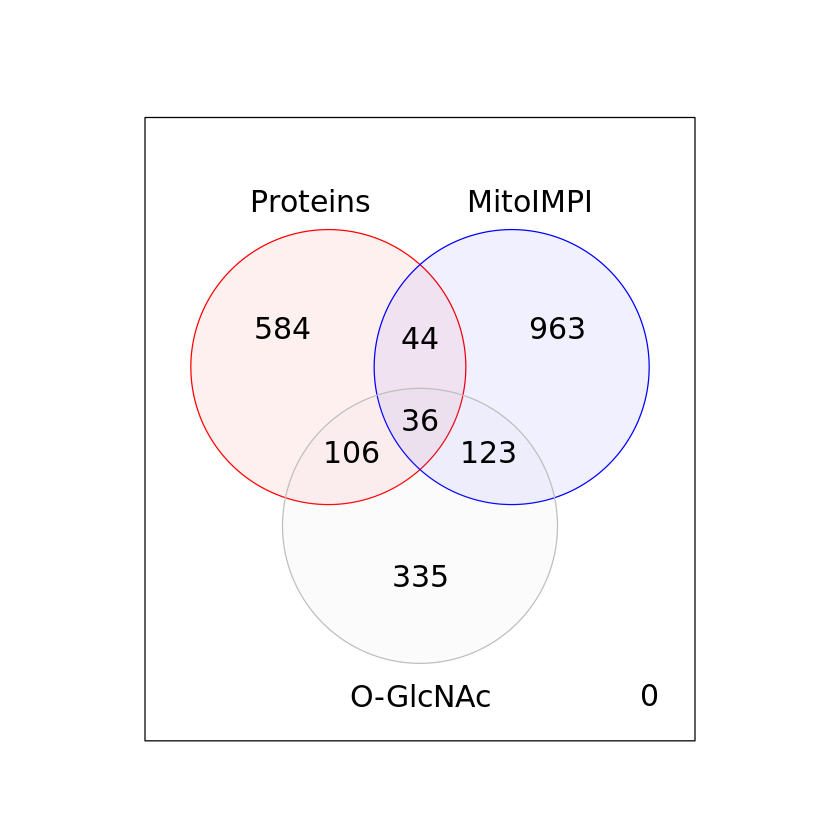

In [21]:
vennInpOverlap <- as.data.frame(matrix(0, nrow=length(unique(c(as.character(IMPI_ver_mito_union.df$Sym),
                                                                   as.character(OGlc_rat$UniSYM),
                                                                   as.character(perInpImpOnly_DGE_limma_786_anno_filt$matchSYM)))), ncol=3))
rownames(vennInpOverlap) <- unique(c(as.character(IMPI_ver_mito_union.df$Sym),
                                     as.character(OGlc_rat$UniSYM),
                                     as.character(perInpImpOnly_DGE_limma_786_anno_filt$matchSYM)))
colnames(vennInpOverlap) <- c("Proteins", "MitoIMPI", "O-GlcNAc")
vennInpOverlap[which(rownames(vennInpOverlap) %in% as.character(perInpImpOnly_DGE_limma_786_anno_filt$matchSYM)),1] <- 1
vennInpOverlap[which(rownames(vennInpOverlap) %in% as.character(IMPI_ver_mito_union.df$Sym)),2] <- 1
vennInpOverlap[which(rownames(vennInpOverlap) %in% as.character(OGlc_rat$UniSYM)),3] <- 1
#pdf(file="YuPekkurnaz_MitoProteomics_FigureS5E_venndiagram.pdf", height=8, width=8)
vennDiagram(vennInpOverlap, circle.col = c("red", "blue", "gray"))
#dev.off()

In [22]:
mitoOverlap <- vennInpOverlap[vennInpOverlap[,1] == 1 & vennInpOverlap[,2] == 1,]
prot786_All_mito <- perInpImpOnly_DGE_limma_786_anno_filt[perInpImpOnly_DGE_limma_786_anno_filt$matchSYM %in% 
                                                           rownames(mitoOverlap),]

## Enrichment Analysis
<a id='enrich'></a>
[Table of Contents](#toc)

In [25]:
# 73 of 80 mitochondrial overlap proteins have unique symbols that can be used as input into the enrichment analysis
MitoOverlaps <- read.csv(file="YuPekkurnaz_MitoProteomics_Mitooverlap_73Proteins_ImpTMM_limmaOutput_anno2.csv")
gostres_Mito <- gost(query = MitoOverlaps$matchSYM, 
                        organism = "rnorvegicus", 
                        ordered_query = FALSE, 
                        multi_query = FALSE, 
                        significant = TRUE, 
                        exclude_iea = FALSE,
                        measure_underrepresentation = FALSE, 
                        evcodes = TRUE,
                        user_threshold = 0.05, 
                        correction_method = "fdr",
                        domain_scope = "custom_annotated", 
                        custom_bg = unique(c(perInpImpOnly_DGE_limma_786_anno_filt$UniSYM, MitoOverlaps$matchSYM)),
                        numeric_ns = "", 
                        sources = NULL, 
                        as_short_link = FALSE)
gpro_res_Mito <- gostres_Mito$result[,c("p_value", "term_size", "query_size", "intersection_size", "precision","recall", "term_id", "source", "term_name", "intersection")]

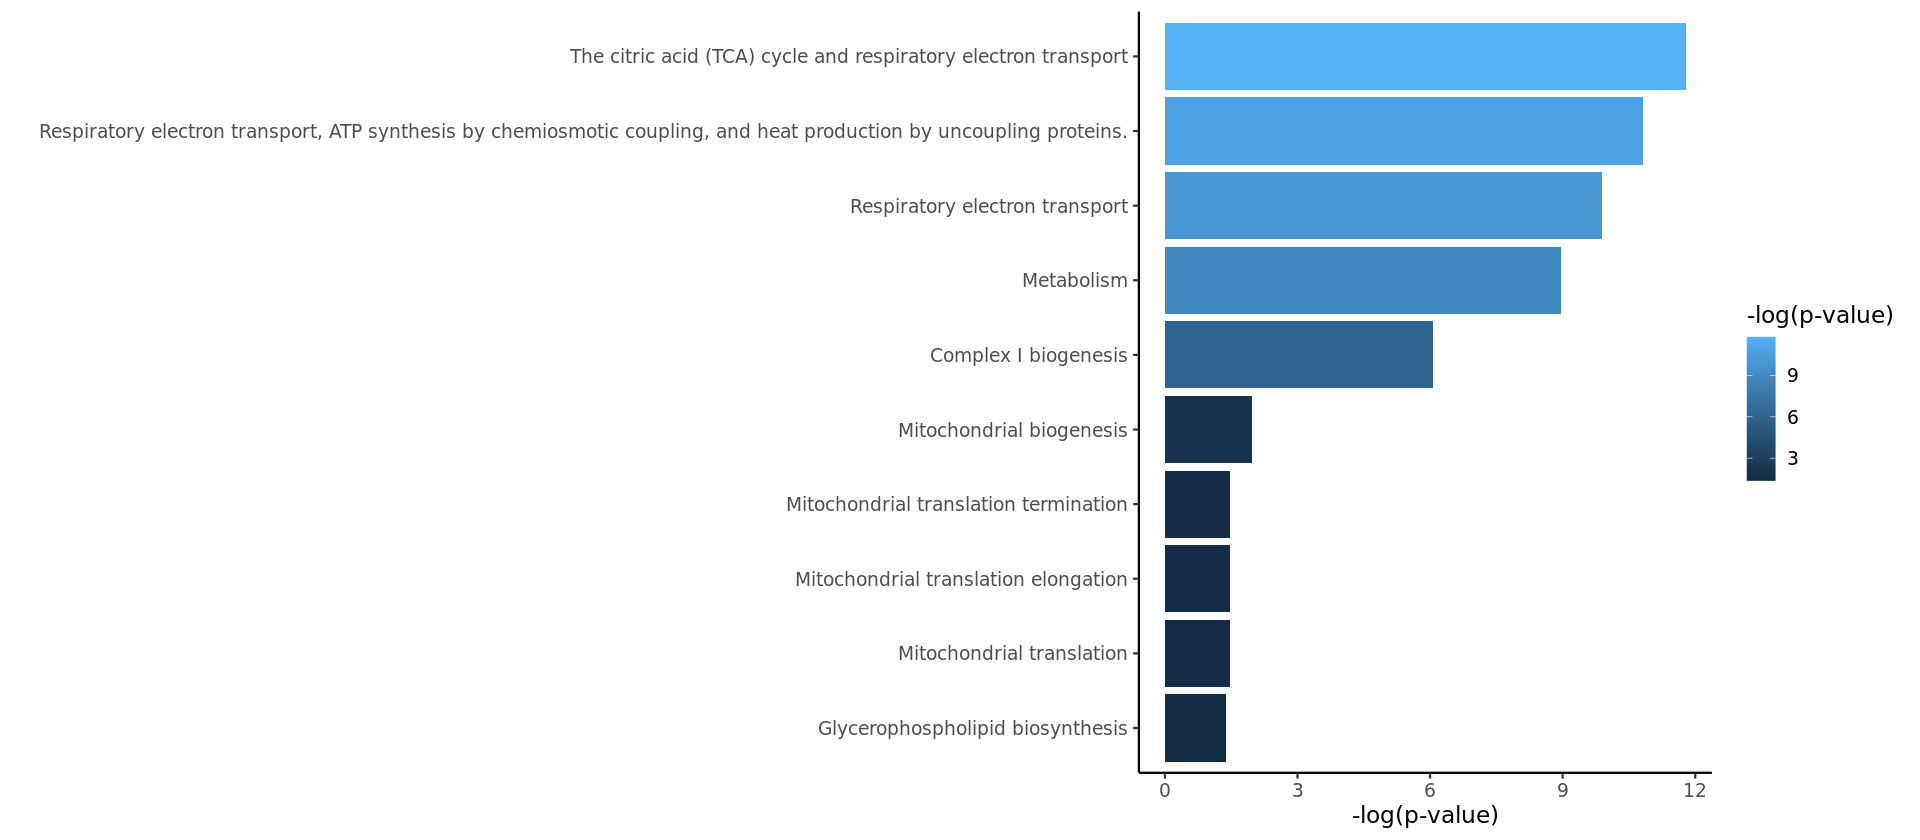

In [24]:
gpro_res_Mito_REAC <- gpro_res_Mito[grep("REAC", gpro_res_Mito$source),]
gpro_res_Mito_REAC$"-log(p-value)" <- -log(gpro_res_Mito_REAC$p_value, 10)
gpro_res_Mito_REAC$gene.ratio <- gpro_res_Mito_REAC$intersection_size/gpro_res_Mito_REAC$term_size
colnames(gpro_res_Mito_REAC)[4] <- "Count" 

options(repr.plot.width=16, repr.plot.height=7)
barplot.inp <- gpro_res_Mito_REAC[1:10,]
barplot.inp$term_name <- factor(barplot.inp$term_name, 
                                levels=barplot.inp$term_name[order(barplot.inp$`-log(p-value)`, decreasing=FALSE)])
S1 <- ggplot(barplot.inp, aes(x=`-log(p-value)`, y=term_name, fill=`-log(p-value)`)) + 
#geom_bar(stat='identity') + 
theme_classic(base_size=14) + ylab("") + xlab("-log(p-value)") + geom_col()
S1

## Generate Plots for Figures
<a id='GenerateFigPlots'></a>
[Table of Contents](#toc)

Warning message:
“Removed 17 rows containing missing values (geom_point).”


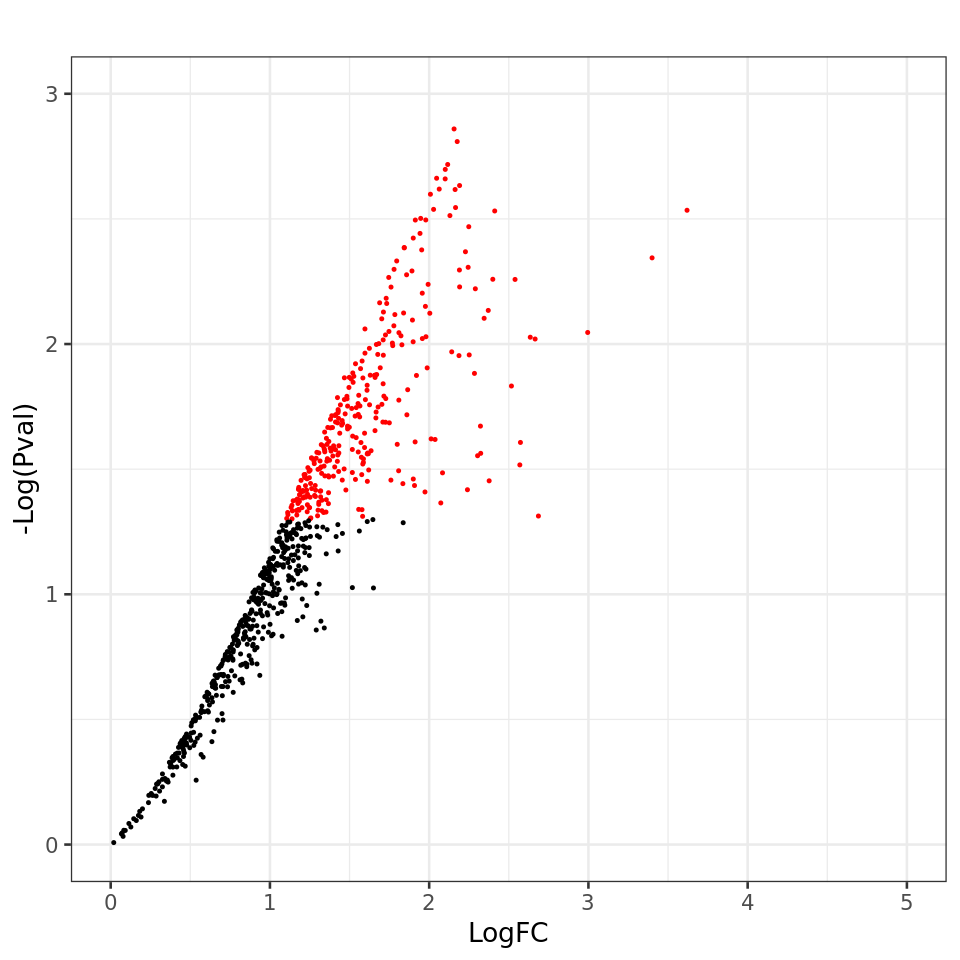

In [26]:
x <- perInpImpOnly_DGE_limma_786_anno_filt
x$neglogq <- -log((as.numeric(x$adj.P.Val)+0.0000000000001), 10)
x$neglogp <- -log((as.numeric(x$P.Value)+0.0000000000001), 10)
x$sig <- factor(as.numeric(x$neglogp) > 1.299)
x$label <- ""
x$label[as.numeric(x$neglogp) > 1.299][1:20] <- x$UniSYM[as.numeric(x$neglogp) > 1.299][1:20]
options(repr.plot.width=8, repr.plot.height=8)
#pdf(file="YuPekkarnuz_MitoProteomics_Figure5B_pval_0.05_update.pdf", width=6, height=6)
p <- ggplot(x, aes(x=logFC, y=neglogp)) + geom_point(aes(colour=sig), size=0.75) + xlim(0, 5) + ylim(0,3) +
        theme_bw(base_size=16) + ylab("-Log(Pval)") + labs(title="") +  xlab("LogFC") + 
        scale_color_manual(values=c("black", "red")) + theme(legend.position="none") #+
show(p)
#dev.off()

In [27]:
# MGI annotation file containing cellular location 
MGI.df <- read.csv("./Data/MGIBatchReport_20220317_144345.csv", header=TRUE, stringsAsFactors=FALSE)
head(MGI.df)
primary_local <- c("Endoplasmic reticulum", "Lysosome", "Endosome", "Golgi", "Peroxisome", "Cytoskeleton", 
                   "Stress granules", "Glycolytic")

,Input,Input.Type,MGI.Gene.Marker.ID,Symbol,Name,Feature.Type,GO.ID,Term,Code
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Scyl2,current symbol,MGI:1289172,Scyl2,SCY1-like 2 (S. cerevisiae),protein coding gene,GO:0005524,ATP binding,IEA
2,Scyl2,current symbol,MGI:1289172,Scyl2,SCY1-like 2 (S. cerevisiae),protein coding gene,GO:0007420,brain development,IDA
3,Scyl2,current symbol,MGI:1289172,Scyl2,SCY1-like 2 (S. cerevisiae),protein coding gene,GO:0031410,cytoplasmic vesicle,IEA
4,Scyl2,current symbol,MGI:1289172,Scyl2,SCY1-like 2 (S. cerevisiae),protein coding gene,GO:0005768,endosome,IEA
5,Scyl2,current symbol,MGI:1289172,Scyl2,SCY1-like 2 (S. cerevisiae),protein coding gene,GO:0008333,endosome to lysosome transport,ISO
6,Scyl2,current symbol,MGI:1289172,Scyl2,SCY1-like 2 (S. cerevisiae),protein coding gene,GO:0005794,Golgi apparatus,IEA


In [28]:
MGI.df2 <- MGI.df[-grep("regulation of|activity|process|transport|translocation|binding|signaling|organization|release|
export|import", MGI.df$Term),]

In [29]:
MGI.df2_mito <- MGI.df2[grep("^mitochondrion$", tolower(MGI.df2$Term)),]
MGI.df2_mito <- MGI.df2_mito[!duplicated(MGI.df2_mito[,1]),]
MGI.df2_mito$Term <- "Mitochondrion"

In [30]:
MGI.df2_mito <- MGI.df2[MGI.df2$Input %in% IMPI_ver_mito_union.df2$Sym | 
                         MGI.df2$Input %in% "Atad3",]
MGI.df2_mito <- MGI.df2_mito[!duplicated(MGI.df2_mito[,c(1)]),]
MGI.df2_mito$Term <- "Mitochondrion"
MGI.genes_rem <- MGI.df2_mito$Input
MGI.df2_A <- MGI.df2[!MGI.df2$Input %in% MGI.genes_rem,]
MGI.df2_golgi <- MGI.df2_A[grep("^golgi", tolower(MGI.df2_A$Term)),]
MGI.df2_golgi <- MGI.df2_golgi[!duplicated(MGI.df2_golgi[,1:6]),]
MGI.df2_golgi$Term <- "Golgi"
MGI.genes_rem <- c(MGI.genes_rem, MGI.df2_golgi$Input)
MGI.df2_B <- MGI.df2_A[!MGI.df2_A$Input %in% MGI.genes_rem,]
MGI.df2_lys <- MGI.df2_B[grep("lysosome$", tolower(MGI.df2_B$Term)),]
MGI.df2_lys <- MGI.df2_lys[!duplicated(MGI.df2_lys[,1:6]),]
MGI.df2_lys$Term <- "Lysosome"
MGI.genes_rem <- c(MGI.genes_rem, MGI.df2_lys$Input)
MGI.df2_C <- MGI.df2_B[!MGI.df2_B$Input %in% MGI.genes_rem,]
MGI.df2_endo <- MGI.df2_C[grep("endosome$", tolower(MGI.df2_C$Term)),]
MGI.df2_endo <- MGI.df2_endo[!duplicated(MGI.df2_endo[,1:6]),]
MGI.df2_endo$Term <- "Endosome"
MGI.genes_rem <- c(MGI.genes_rem, MGI.df2_endo$Input)
MGI.df2_D <- MGI.df2_C[!MGI.df2_C$Input %in% MGI.genes_rem,]
MGI.df2_perox <- MGI.df2_D[grep("peroxisome$", tolower(MGI.df2_D$Term)),]
MGI.df2_perox <- MGI.df2_perox[!duplicated(MGI.df2_perox[,1:6]),]
MGI.df2_perox$Term <- "Peroxisome"
MGI.genes_rem <- c(MGI.genes_rem, MGI.df2_perox$Input)
MGI.df2_E <- MGI.df2_D[!MGI.df2_D$Input %in% MGI.genes_rem,]
MGI.df2_prim <- MGI.df2_E[tolower(MGI.df2_E$Term) %in% tolower(primary_local[-c(2:5,9)]),]
MGI.df2_prim <- MGI.df2_prim[!duplicated(MGI.df2_prim[,1]),]
#MGI.df2_prim$Term <- "Cytosol"
MGI.genes_rem <- c(MGI.genes_rem, MGI.df2_prim$Input)
MGI.df2_F <- MGI.df2_E[!MGI.df2_E$Input %in% MGI.genes_rem,]
MGI.df2_cyto <- MGI.df2_F[grep("cytosol$|cytoplasm$", tolower(MGI.df2_F$Term)),]
MGI.df2_cyto <- MGI.df2_cyto[!duplicated(MGI.df2_cyto[,1:6]),]
MGI.df2_cyto$Term <- "Cytosol"
MGI.genes_rem <- c(MGI.genes_rem, MGI.df2_cyto$Input)
MGI.df2_G <- MGI.df2_F[!MGI.df2_F$Input %in% MGI.genes_rem,]
MGI.df2_nucleus <- MGI.df2_G[grep("nucleus$|nucleoplasm$", tolower(MGI.df2_G$Term)),]
MGI.df2_nucleus <- MGI.df2_nucleus[!duplicated(MGI.df2_nucleus[,1:6]),]
MGI.df2_nucleus$Term <- "Nucleus"
MGI.genes_rem <- c(MGI.genes_rem, MGI.df2_nucleus$Input)
MGI.df2_H <- MGI.df2_G[!MGI.df2_G$Input %in% MGI.genes_rem,]
MGI.df2_axon <- MGI.df2_H[grep("axon", tolower(MGI.df2_G$Term)),]
MGI.df2_axon <- MGI.df2_axon[!duplicated(MGI.df2_axon[,1:6]),]
MGI.df2_axon$Term <- "Axon"
MGI.genes_rem <- c(MGI.genes_rem, MGI.df2_axon$Input)

MGI.df2_terms_1 <- rbind.data.frame(MGI.df2_mito, MGI.df2_lys, MGI.df2_endo, MGI.df2_perox, 
                                    MGI.df2_cyto, MGI.df2_nucleus, MGI.df2_axon, MGI.df2_golgi, MGI.df2_prim)

In [31]:
MGI.df_genes_1 <- unique(c(MGI.df2$Input[grep("^golgi", tolower(MGI.df2$Term))],
MGI.df2$Input[grep("lysosome$", tolower(MGI.df2$Term))],
MGI.df2$Input[grep("endosome$", tolower(MGI.df2$Term))],
MGI.df2$Input[grep("peroxisome$", tolower(MGI.df2$Term))],
MGI.df2$Input[grep("cytosol$|cytoplasm$", tolower(MGI.df2$Term))],
MGI.df2$Input[grep("nucleus$|nucleoplasm$", tolower(MGI.df2$Term))],
MGI.df2$Input[grep("axon", tolower(MGI.df2$Term))],
MGI.df2$Input[tolower(MGI.df2$Term) %in% tolower(primary_local)],
MGI.df2_mito$Input
))

MGI.df2_filt_1 <- MGI.df2[!MGI.df2$Input %in% MGI.df_genes_1,]

In [32]:
#write.csv(MGI.df2_filt_1, file="MGIBatchReport_firstround_filt.csv")
MGI.df2_filt_2 <- read.csv(file="./Data/MGIBatchReport_firstround_filt_output.csv", header=TRUE, stringsAsFactors=FALSE)
MGI.df2_filt_comb <- rbind.data.frame(MGI.df2_terms_1, MGI.df2_filt_2)
MGI.df2_filt_pieinp <- as.data.frame(table(MGI.df2_filt_comb$Term))
MGI.df2_filt_pieinp <- MGI.df2_filt_pieinp[MGI.df2_filt_pieinp$Freq > 3,]

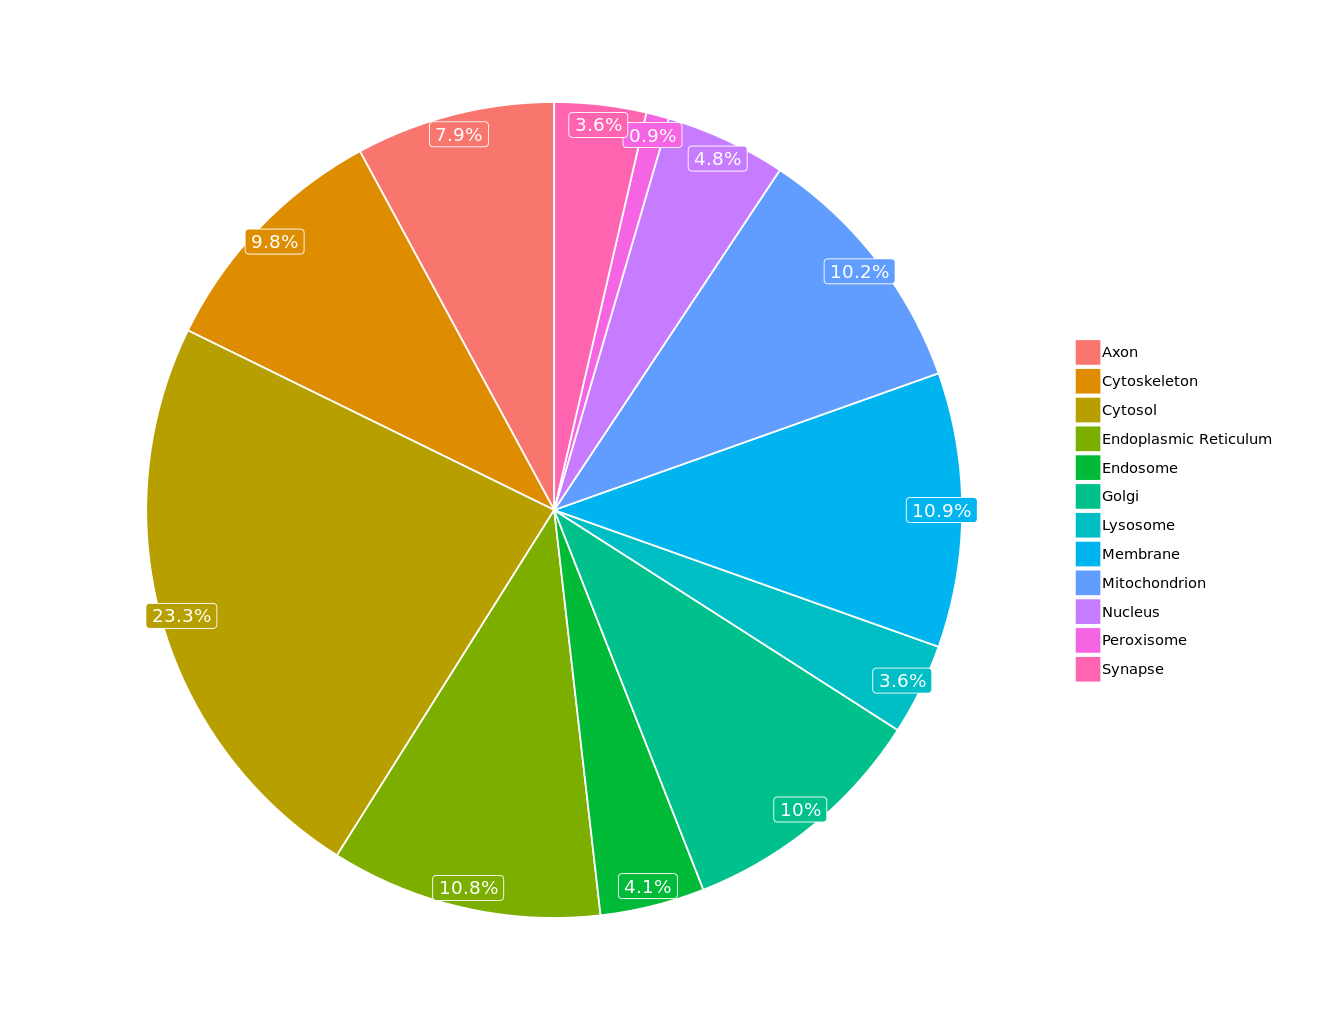

In [33]:
MGI.df2_filt_pieinp$Percent <- round(100*(MGI.df2_filt_pieinp$Freq/sum(MGI.df2_filt_pieinp[,2])), digits = 1)
MGI.df2_filt_pieinp$labels <- paste0(MGI.df2_filt_pieinp$Percent, "%")
MGI.df2_filt_pieinp$Var1 <- str_to_title(MGI.df2_filt_pieinp$Var1)
options(repr.plot.width=11, repr.plot.height=8.5)
#pdf(file="YuPekkurnaz_MitoProtemics_FigureS5F_SubcellPie.pdf", height=8.5, width=11)
ggplot(MGI.df2_filt_pieinp, aes(x="", y=Freq, fill=Var1)) +
  geom_bar(stat="identity", width=2, color="white") +
    geom_label(aes(label = labels, x=1.9), color = "white",
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  coord_polar("y", start=0) + theme_void() + theme(legend.title=element_text(size=0))
#dev.off()


In [34]:
MGI.df.l <- MGI.df %>% group_by(Input) %>% summarize(Term=list(Term))

In [35]:
# MitoCarta 3.0 annotation file containing submitochondrial location
mito_mouse <- read.csv(file="MitoCarta_mouse.csv", header=TRUE)
prot786_All_mito$MitoLocal <- mito_mouse$MitoCarta3.0_SubMitoLocalization[match(prot786_All_mito$matchSYM,
                                                                                mito_mouse$Symbol)]
prot786_All_mito$MitoLocal <- as.character(prot786_All_mito$MitoLocal)
prot786_All_mito$MitoLocal <- as.character(prot786_All_mito$MitoLocal)
prot786_All_mito$MitoLocal[prot786_All_mito$matchSYM %in% c("Atp5po", "Atp5f1c", "Atp5f1a", "Atp5f1b", "Atp5pd")] <- "MIM"
prot786_All_mito$MitoLocal[prot786_All_mito$matchSYM %in% c("Slit3", "Mark2", "Gramd4", "Hspa5", "Lrrc59",
                                                           "Ddx3x", "Hnrnpk", "Ncstn")] <- "Unknown"
prot786_All_mito$MitoLocal[prot786_All_mito$matchSYM %in% c("Acsl4", "Abce1", "Actb", "Vim", "Sybu", "Ogt",
                                                           "Rps3", "Erbb4", "Nrp1", "Snph", "Slc44a2",
                                                           "Rab5c", "Tmx2")] <- "Associated"

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


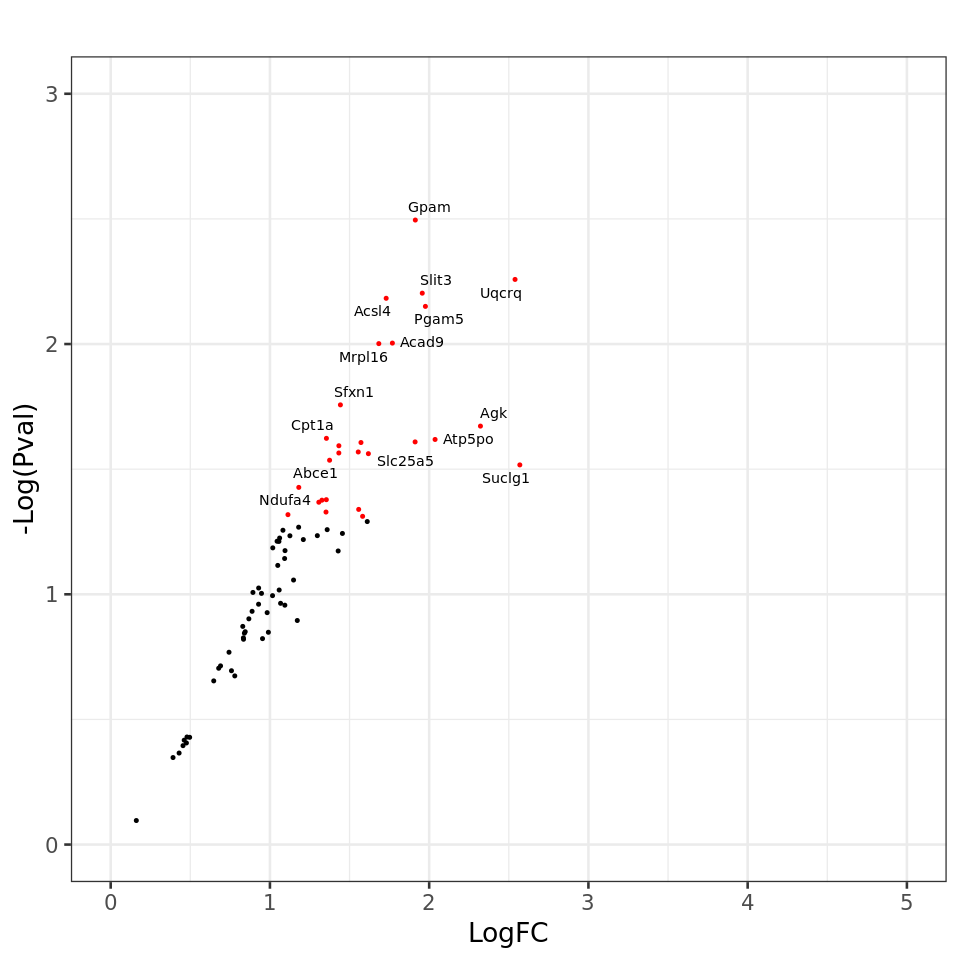

In [36]:
x <- prot786_All_mito
    x$neglogq <- -log((as.numeric(x$adj.P.Val)+0.0000000000001), 10)
    x$neglogp <- -log((as.numeric(x$P.Value)+0.0000000000001), 10)
    #x$sig <- c("black","red")[as.numeric(as.numeric(x$neglogp) > 1.299) + 1]
    x$sig <- factor(as.numeric(x$neglogp) > 1.299)
    x$label <- ""
    x$label[as.numeric(x$neglogp) > 1.299][1:20] <- x$UniSYM[as.numeric(x$neglogp) > 1.299][1:20]
    options(repr.plot.width=8, repr.plot.height=8)
    #pdf(file="YuPekkarnuz_MitoProteomics_Figure5C_pval_0.05_update.pdf", width=6, height=6)
    p <- ggplot(x, aes(x=logFC, y=neglogp)) + geom_point(aes(colour=sig), size=0.75) + xlim(0, 5) + ylim(0,3) +
            theme_bw(base_size=16) + ylab("-Log(Pval)") + labs(title="") +  xlab("LogFC") + 
            scale_color_manual(values=c("black", "red")) + theme(legend.position="none") +
            geom_text_repel(aes(label=label), size=3)
    show(p)
#main="", xlab="LogFC", ylab="-Log(Pval)", pch=19, cex=0.5, col="red", ylim=c(0,5)))
    #dev.off()

In [37]:
# Mitochondrial overlapping proteins with submitochondrial location annotation
prot786_All_mito_subMito <- read.csv("./Data/YuPekkanuz_MitoProteomics_All_Mito_80proteins_submitoloc.csv", header=TRUE)
all_mito_pieinp <- as.data.frame(table(prot786_All_mito_subMito$MitoLocal))
all_mito_pieinp <- all_mito_pieinp[all_mito_pieinp$Freq > 3,]

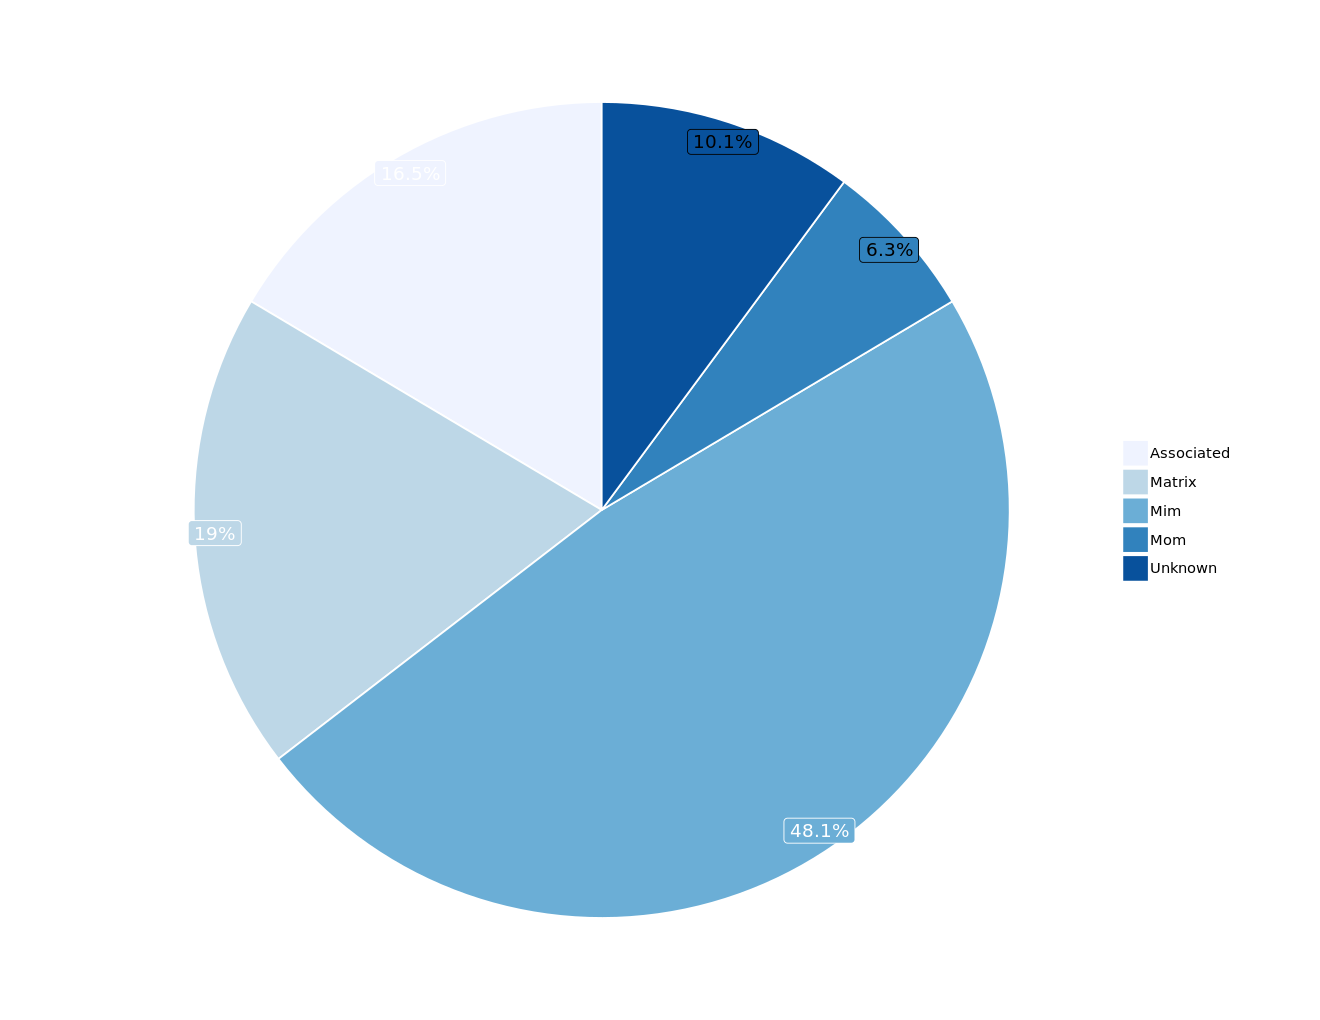

In [38]:
all_mito_pieinp$Var1 <- str_to_title(all_mito_pieinp$Var1)
all_mito_pieinp$Percent <- round(100*(all_mito_pieinp$Freq/sum(all_mito_pieinp[,2])), digits = 1)
all_mito_pieinp$labels <- paste0(all_mito_pieinp$Percent, "%")

options(repr.plot.width=11, repr.plot.height=8.5)
#pdf(file="YuPekkurnaz_MitoProtemics_Figure5F_SubmitoPie.pdf", height=8.5, width=11)
ggplot(all_mito_pieinp, aes(x="", y=Freq, fill=Var1)) + 
scale_fill_brewer(palette="Blues") +
  geom_bar(stat="identity", width=2, color="white") +
    geom_label(aes(label = labels, x=1.9), color = c("white", "white", "white", "black", "black"),
            position = position_stack(vjust = 0.5),
            show.legend = FALSE) +
  coord_polar("y", start=0) + theme_void() + theme(legend.title=element_text(size=0))
#dev.off()


In [39]:
# MitoCarta 3.0 annotation file containing functional mitochondrial pathways
mitopaths <- read.csv(file="./Data/Mouse.MitoCarta3.0_mitopaths.csv", header=TRUE, stringsAsFactors=FALSE)
top_paths <- mitopaths[-grep(">", mitopaths[,2]),]
top_paths$Genes <- gsub(" ", "", top_paths$Genes)

In [40]:
secondmitopaths_overlap.l <- thirdmitopaths_overlap.l <- top_paths_overlap.l <-list()
for (i in 1:nrow(top_paths)) {
    secondmitopaths_overlap.l[[i]] <- thirdmitopaths_overlap.l[[i]] <- top_paths_overlap.l[[i]] <- list()
    names(top_paths_overlap.l)[i] <- top_paths$MitoPathway[i]
    u <- unlist(strsplit(top_paths$Genes[i], split = ","))
    top_paths_overlap.l[[i]] <- prot786_All_mito[prot786_All_mito$SYM %in% u| prot786_All_mito$matchSYM %in% u | 
                                               prot786_All_mito$UniSYM %in% u,]
}
top_paths_overlap.df <- do.call(rbind.data.frame, top_paths_overlap.l) 
top_paths_overlap.df$TopMitoPath <- unlist(lapply(1:length(top_paths_overlap.l), function(i) {
    rep(names(top_paths_overlap.l)[i], nrow(top_paths_overlap.l[[i]]))
}))

In [41]:
t <- mitopaths[grep(">", mitopaths[,2]),1:3]
Second_paths <- do.call(rbind.data.frame, lapply(1:nrow(t), function(i) {
    s <- strsplit(t$MitoPathway.Hierarchy[i], split = ">")
    if(length(s[[1]]) == 2) {
    return(as.vector(c(t[i,1:3], s[[1]][1], s[[1]][2])))
       }
       }))
colnames(Second_paths)[4:5] <- c("TopPath", "SecondPath")
Second_paths$Genes <- gsub(" ", "", Second_paths$Genes)
Third_paths <- do.call(rbind.data.frame, lapply(1:nrow(t), function(i) {
    s <- strsplit(t$MitoPathway.Hierarchy[i], split = ">")
    if(length(s[[1]]) == 3) {
    return(as.vector(c(t[i,1:3], s[[1]][1], s[[1]][2], s[[1]][3])))
       }
       }))
colnames(Third_paths)[4:6] <- c("TopPath", "SecondPath", "ThirdPath")
Third_paths$Genes <- gsub(" ", "", Third_paths$Genes)

In [42]:
for (i in 1:nrow(Second_paths)) {
    secondmitopaths_overlap.l[[i]] <- list()
    names(secondmitopaths_overlap.l)[i] <- as.character(Second_paths$SecondPath)[i]
    u <- unlist(strsplit(as.character(Second_paths$Genes)[i], split = ","))
    secondmitopaths_overlap.l[[i]] <- prot786_All_mito[prot786_All_mito$SYM %in% u| prot786_All_mito$matchSYM %in% u | 
                                               prot786_All_mito$UniSYM %in% u,]
}
Second_paths_sum.df <- data.frame(Total=unlist(lapply(1:nrow(Second_paths), function(i) length(unlist(strsplit(as.character(Second_paths$Genes)[i], split=","))))),
                                  SecondPath=as.character(Second_paths$SecondPath))
Second_paths_sum.df$TopPath <- as.character(Second_paths$TopPath)[match(Second_paths_sum.df$SecondPath,
                                                                       as.character(Second_paths$SecondPath))]
Second_paths_overlap_sum.df <- data.frame(Total=unlist(lapply(secondmitopaths_overlap.l, nrow)),
                                          SecondPath=names(secondmitopaths_overlap.l))
Second_paths_overlap_sum.df$TopPath <- as.character(Second_paths$TopPath)[match(Second_paths_overlap_sum.df$SecondPath,
                                                                                as.character(Second_paths$SecondPath))]
Second_paths_overlap_sum.df$TotalProteins <- Second_paths_sum.df$Total[match(Second_paths_overlap_sum.df$SecondPath,
                                                                             Second_paths_sum.df$SecondPath)]
second_paths_overlap.df <- do.call(rbind.data.frame, secondmitopaths_overlap.l) 

second_paths_overlap.df$SecondMitoPath <- unlist(lapply(1:length(secondmitopaths_overlap.l), function(i) {
    rep(names(secondmitopaths_overlap.l)[i], nrow(secondmitopaths_overlap.l[[i]]))
}))
second_paths_overlap.df$TopMitoPath <- as.character(Second_paths$TopPath)[match(second_paths_overlap.df$SecondMitoPath,
                                                                  as.character(Second_paths$SecondPath))]



In [43]:
for (i in 1:nrow(Third_paths)) {
    thirdmitopaths_overlap.l[[i]] <- list()
    names(thirdmitopaths_overlap.l)[i] <- as.character(Third_paths$ThirdPath)[i]
    u <- unlist(strsplit(as.character(Third_paths$Genes)[i], split = ","))
    thirdmitopaths_overlap.l[[i]] <- prot786_All_mito[prot786_All_mito$SYM %in% u| prot786_All_mito$matchSYM %in% u | 
                                               prot786_All_mito$UniSYM %in% u,]
}

Third_paths_sum.df <- data.frame(Total=unlist(lapply(1:nrow(Third_paths), function(i) length(unlist(strsplit(as.character(Third_paths$Genes)[i], split=","))))),
                                 ThirdPath=as.character(Third_paths$ThirdPath))
Third_paths_sum.df$SecondPath <- as.character(Third_paths$SecondPath)[match(Third_paths_sum.df$ThirdPath,
                                                                      as.character(Third_paths$ThirdPath))]
Third_paths_sum.df$TopPath <- as.character(Third_paths$TopPath)[match(Third_paths_sum.df$ThirdPath,
                                                                      as.character(Third_paths$ThirdPath))]
Third_paths_overlap_sum.df <- data.frame(Total=unlist(lapply(thirdmitopaths_overlap.l, nrow)))
Third_paths_overlap_sum.df$ThirdPath <- rownames(Third_paths_overlap_sum.df)
Third_paths_overlap_sum.df$SecondPath <- as.character(Third_paths$SecondPath)[match(Third_paths_overlap_sum.df$ThirdPath,
                                                                                as.character(Third_paths$ThirdPath))]
Third_paths_overlap_sum.df$TopPath <- as.character(Third_paths$TopPath)[match(Third_paths_overlap_sum.df$ThirdPath,
                                                                                as.character(Third_paths$ThirdPath))]
Third_paths_overlap_sum.df$TotalProteins <- Third_paths_sum.df$Total[match(Third_paths_overlap_sum.df$ThirdPath,
                                                                             Third_paths_sum.df$ThirdPath)]
third_paths_overlap.df <- do.call(rbind.data.frame, thirdmitopaths_overlap.l) 

third_paths_overlap.df$ThirdMitoPath <- unlist(lapply(1:length(thirdmitopaths_overlap.l), function(i) {
    rep(names(thirdmitopaths_overlap.l)[i], nrow(thirdmitopaths_overlap.l[[i]]))
}))
third_paths_overlap.df$SecondMitoPath <- as.character(Third_paths$SecondPath)[match(third_paths_overlap.df$ThirdMitoPath,
                                                                  as.character(Third_paths$ThirdPath))]
third_paths_overlap.df$TopMitoPath <- as.character(Third_paths$TopPath)[match(third_paths_overlap.df$ThirdMitoPath,
                                                                  as.character(Third_paths$ThirdPath))]


## References
<a id='ref'></a>

1. Cox J, Hein MY, Luber CA, Paron I, Nagaraj N, Mann M. Accurate proteome-wide label-free quantification by delayed normalization and maximal peptide ratio extraction, termed MaxLFQ. Mol Cell Proteomics. 2014 Sep;13(9):2513-26. doi: 10.1074/mcp.M113.031591. Epub 2014 Jun 17. PubMed PMID: 24942700; PubMed Central PMCID: PMC4159666.
2. Tyanova S, Temu T, Sinitcyn P, Carlson A, Hein MY, Geiger T, Mann M, Cox J. The Perseus computational platform for comprehensive analysis of (prote)omics data. Nat Methods. 2016 Sep;13(9):731-40. doi: 10.1038/nmeth.3901. Epub 2016 Jun 27. PubMed PMID: 27348712.
3. Ritchie ME, Phipson B, Wu D, Hu Y, Law CW, Shi W, Smyth GK. limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Res. 2015 Apr 20;43(7):e47. doi: 10.1093/nar/gkv007. Epub 2015 Jan 20. PubMed PMID: 25605792; PubMed Central PMCID: PMC4402510.
4. Mootha VK, Lindgren CM, Eriksson K-F, Subramanian A, Sihag A, Lehar J, Puigserver P, Carlsson E, Ridderstråle M, Laurila E, Houstis N, Daly MJ, Patterson N, Mesirov JP, Golub TR, Tamayo P, Spiegelman B, Lander ES, Hirschhorn JN, Altshuler D, Groop LC. PGC-1α-responsive genes involved in oxidative phosphorylation are coordinately downregulated in human diabetes. Nature Genetics volume 34, pages 267–273 (2003).
5. Subramanian A, Tamayo P, Mootha VK, Mukherjee S, Ebert BL, Gillette MA, Paulovich A, Pomeroy SL, Golub TR, Lander ES, Mesirov JP. Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles. Proceedings of the National Academy of Sciences Oct 2005, 102 (43) 15545-15550; DOI: 10.1073/pnas.0506580102.

[Table of Contents](#toc)

## Appendix: R Session Info
<a id='app'></a>

In [44]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/ubuntu/anaconda3/envs/rbase_4_1/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] IRdisplay_1.1        gprofiler2_0.2.1     ggrepel_0.9.1       
 [4] reshape2_1.4.4       org.Hs.eg.db_3.14.0  RColorBrewer_1.1-3  
 [7] dplyr_1.0.9          plyr_1.8.7           ggpubr_0.4.0        
[10] gplots_3.1.3         ggplot2_3.3.6        stringr_1.4.0       
[13] limma_3.50.3         org.Rn.eg.db_3.14.0  AnnotationDbi_1.56.2
[16] I